In [63]:
#! usr/bin/env python3
import praw
import pandas as pd
from datetime import datetime as dt
import time, calendar
import psycopg2
import time
import pymongo
starttime=time.time()
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from scipy.stats import linregress




In [10]:
# Write file to dataFrame
filepath = "df_reddit.csv"

dataframereddit = pd.read_csv(filepath, sep = '\t', encoding ='utf-8', parse_dates=['Created'])
dataframereddit


,Unnamed: 0,ID,Title,Body,Score,URL,Comments,Created
0,0,ejl023,Perfect timing,NaN,17413,https://v.redd.it/ayzsxc2tfm841,315,2020-01-04 04:14:06
1,1,ejk48x,TIL Research shows that children as young as 4...,NaN,23802,https://news.yale.edu/2018/07/23/even-4-year-o...,1116,2020-01-04 03:14:08
2,2,ejk3qx,In The Lego Movie (2014) Benny the spaceman ha...,NaN,18413,https://i.redd.it/1yf0ofvx4m841.jpg,264,2020-01-04 03:13:11
3,3,ejjmjr,Recommendations!,NaN,24502,https://i.redd.it/j6e4ge34zl841.jpg,101,2020-01-04 02:40:32
4,4,ejkcib,New Years photobomb!,NaN,11507,https://i.redd.it/1dashplv7m841.jpg,173,2020-01-04 03:29:40
...,...,...,...,...,...,...,...,...
6268834,7172467,el49up,"umm, oopsie!",NaN,344,https://i.redd.it/rldx31cqi9941.jpg,11,2020-01-07 09:51:27
6268835,7172468,elbkks,So do you want the green meth or the blue meth?,NaN,43,https://i.redd.it/2wuua1bfzc941.jpg,4,2020-01-07 21:30:22
6268836,7172469,elb5dc,Ah yes happened yesterday,NaN,45,https://i.redd.it/i82z1sx7sc941.jpg,1,2020-01-07 20:49:58
6268837,7172471,elbngo,Me Trying to sleep,NaN,40,https://i.redd.it/lflndbnq0d941.png,1,2020-01-07 21:37:44


In [486]:
# Cleaning work
work = dataframereddit.copy()
work.drop(['Body', 'URL', 'Unnamed: 0', 'Title'], axis=1, inplace = True)
work.dropna(axis=0, how='any', thresh=None, subset=['Score', 'Comments', 'Created'] , inplace=True)
work.drop_duplicates(subset = ['Created'], inplace = True)
work


,ID,Score,Comments,Created
0,ejl023,17413,315,2020-01-04 04:14:06
1,ejk48x,23802,1116,2020-01-04 03:14:08
2,ejk3qx,18413,264,2020-01-04 03:13:11
3,ejjmjr,24502,101,2020-01-04 02:40:32
4,ejkcib,11507,173,2020-01-04 03:29:40
...,...,...,...,...
6268830,elbovy,43,2,2020-01-07 21:41:11
6268832,elbl79,43,1,2020-01-07 21:32:03
6268833,elbo8n,40,3,2020-01-07 21:39:39
6268835,elbkks,43,4,2020-01-07 21:30:22


In [329]:
# Important info

# Next step: do an analysis of the data to determine if there is a significant difference in 
# average score values in the beginning of the day, and the end of the day. then do the same for comments


# work.mean()
# Score avg = 2385.594459
# Comments avg = 68.359865
# Total hours = 109
# work.Score.max() = 151464
# work.Score.min() = 36
# comments min = 0
# comments max = 56981
# created max= 2020-01-07 21:41:52
# Created min = 2020-01-03 07:04:51
# work.Created.max()-work.Created.min() =  Timedelta('4 days 14:37:01')
# After checking for data errors, i have removed things after 2020-01-06 8:30:00. I had 
# somehow scraped posts from those dates despite stopping to scrape at that max time
# time delta = 3 days, 1 hour, 25 minutes and 9 seconds

TypeError: unsupported operand type(s) for -: 'str' and 'str'

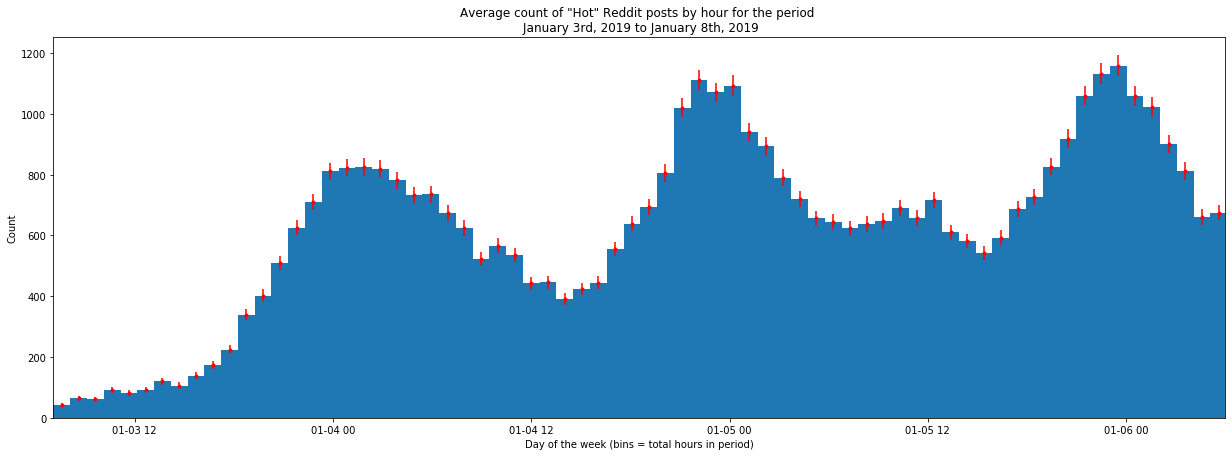

In [487]:
# Here we show a histogram by day of the counts of posts binned into hours
work.sort_values(by=['Score'], ascending = False, inplace = True)
data = work.Created
data1 = work.copy()
data1.set_index('Score', inplace = True)
data1.drop(['ID', 'Comments'], axis = 1, inplace = True)

fig, ax = plt.subplots(figsize=([21,7]))

entries1, edges1, _ = plt.hist(data1.Created, bins=109)

# # calculate bin centers
bin_centers = 0.5 * (edges1[:-1] + edges1[1:])

# # draw errorbars, use the sqrt error. You can use what you want there
# # poissonian 1 sigma intervals would make more sense
plt.errorbar(bin_centers, entries1, yerr=np.sqrt(entries1), fmt='r.')


ax.set_xlabel('Day of the week (bins = total hours in period)')
ax.set_ylabel('Count')

ax.set_title('Average count of "Hot" Reddit posts by hour for the period \n January 3rd, 2019 to January 8th, 2019')
# ax.set_xticks(ticks=list(range(0,121))) 
plt.xlim('2020-01-03 07:04:51', '2020-01-06 6:00:00')
plt.show()



In [186]:
study_df = work.copy()
study_df['68+ comments?'] = study_df['Comments'].apply(lambda x: 1 if x > 68 else 0)
# df['Normal'] = df.Speed.apply(lambda x: 1 if x == "Normal" else 0)

df_high_comments = study_df[study_df['Comments'] > 300] 
df_high_comments.drop_duplicates()

,ID,Score,Comments,Created,68+ comments?
3111129,ek33p5,151464,1069,2020-01-05 05:50:50,1
4887766,ekehvg,146999,2463,2020-01-05 23:39:27,1
4797052,ekcm64,138583,3878,2020-01-05 20:48:52,1
2177414,ejwxed,133345,7105,2020-01-04 21:59:08,1
6266062,el1g2a,125388,1690,2020-01-07 06:23:25,1
...,...,...,...,...,...
2490116,ekc0yj,99,752,2020-01-05 19:44:43,1
4887924,ekrkol,97,2677,2020-01-06 17:04:16,1
805336,ejxydi,94,644,2020-01-04 23:30:25,1
3002887,ekgc53,93,366,2020-01-06 01:51:51,1


In [194]:
df_high_score = study_df[study_df['Score']>5000]
# Is there a significant relationship between high score and high amount of comments useless test
stats.ttest_ind(df_high_score.Score.sample(2741), df_high_comments.Comments)


Ttest_indResult(statistic=51.87214840434686, pvalue=0.0)

In [192]:
df_high_comments.Comments

3111129    1069
4887766    2463
4797052    3878
2177414    7105
6266062    1690
           ... 
2490116     752
4887924    2677
805336      644
3002887     366
2626099     355
Name: Comments, Length: 2741, dtype: int64

In [305]:
# test_df['Score']= scorework.groupby(work["Created"].dt.hour).count()
test_df
scorework.groupby(work["Created"].dt.hour).count().drop('Created', axis =1)
commentwork.groupby(work["Created"].dt.hour).count()

,Comments
Created,
0,654
1,620
2,520
3,501
4,438
5,442
6,306
7,332
8,304


In [335]:
# Analysis of the score count and comment count by date time, dont use this.
stats.ttest_ind(scorework.groupby(work["Created"].dt.hour).count(), commentwork.groupby(work["Created"].dt.hour).count())

Ttest_indResult(statistic=array([11.4070408]), pvalue=array([5.25516666e-15]))

In [262]:
# Analysis chi square work
# From this analysis we can see that their is indeed a strong correlation between
# Hypothesis: Their is a strong correlation between the number of posts with a score above the average 
# and the number of posts with a number of comments above the average


Scorearray = scorework.groupby(work["Created"].dt.hour).count().Score.values
Commentarray = commentwork.groupby(work["Created"].dt.hour).count().Comments.values

# degrees of freedom = (#rows - 1)(#columns -1)
stats.chi2_contingency([Scorearray, Commentarray])

(83.67573851311334,
 7.98404737381813e-09,
 23,
 array([[770.99510806, 757.27110105, 656.30162091, 621.99160339,
         558.76314252, 546.99970794, 623.46203271, 567.09557535,
         544.54899241, 538.17713201, 502.39668516, 438.18793808,
         430.83579147, 354.86360981, 343.59031834, 328.39588201,
         392.11448598, 412.21035339, 485.2416764 , 533.76584404,
         653.85090537, 746.48795269, 795.99240654, 822.46013435],
        [802.00489194, 787.72889895, 682.69837909, 647.00839661,
         581.23685748, 569.00029206, 648.53796729, 589.90442465,
         566.45100759, 559.82286799, 522.60331484, 455.81206192,
         448.16420853, 369.13639019, 357.40968166, 341.60411799,
         407.88551402, 428.78964661, 504.7583236 , 555.23415596,
         680.14909463, 776.51204731, 828.00759346, 855.53986565]]))

In [321]:
work["Created"].dt.hour.count()
scorework.groupby(work["Created"].dt.hour)
# print(scorework.groupby(work["Created"].dt.hour).count())
# print(commentwork.groupby(work["Created"].dt.hour).count())


In [345]:
commentwork.groupby(work["Created"].dt.hour).count()

,Comments
Created,
0,592
1,560
2,490
3,477
4,412
5,432
6,460
7,420
8,407


In [327]:

# Levene test's for homogeneity of variance. based on this result, our distributions have homogeneity of variance. 
# LeveneResult(statistic=2.1144838112791864, pvalue=0.15270077045083622)
# look into this but might be misusing

# Test to see if the distributions of comments and scores are distributed the same way and check for correlation. Based on these results, 

linregress(test_df.Comments, test_df.score)
# LinregressResult(slope=0.7201054004643407, intercept=140.37533237979238, rvalue=0.9452649679056034, pvalue=3.530163024823596e-12, stderr=0.05299723792802816)


LinregressResult(slope=0.7201054004643407, intercept=140.37533237979238, rvalue=0.9452649679056034, pvalue=3.530163024823596e-12, stderr=0.05299723792802816)

In [328]:
stats.levene(test_df.Comments, test_df.score)

LeveneResult(statistic=2.1144838112791864, pvalue=0.15270077045083622)

101

In [256]:
# Next step: do an analysis of the data to determine if there is a significant difference in 
# average score values in the beginning of the day, and the end of the day. then do the same for comments


Timedelta('4 days 14:37:01')

In [317]:
# removed posts with score < than rounded average value

scorework = work.copy()

scorework = scorework[scorework['Score'] > 2385]
# x = work['Score']
scorework['Created'] = pd.to_datetime(work['Created'], errors='coerce')

scorework.drop(['ID', 'Comments', 'Created'], axis=1, inplace = True)


Timestamp('2020-01-07 21:41:52')

In [311]:
# removed posts with # of comments < than rounded average value
commentwork = work.copy()

commentwork = commentwork[commentwork['Comments'] > 68]
# x = work['Score']
commentwork['Created'] = pd.to_datetime(work['Created'], errors='coerce')


commentwork.drop(['ID', 'Score', 'Created'], axis=1, inplace = True)


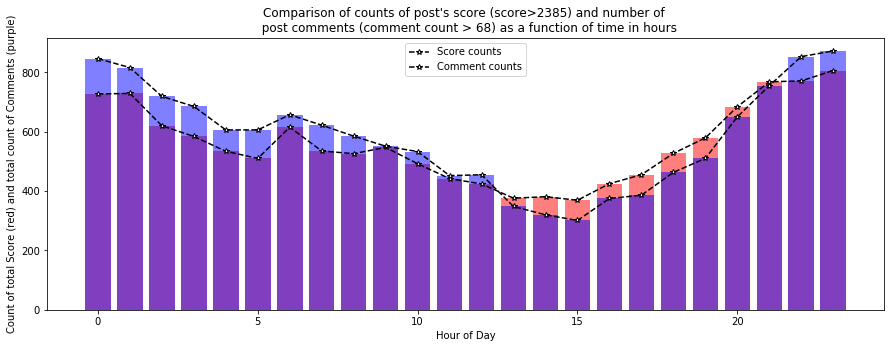

In [319]:
test_df = commentwork.groupby(work["Created"].dt.hour).count()
test_df['score']= scorework.groupby(work["Created"].dt.hour).count()
test_df['Created'] = list(range(0,24))
fig, ax = plt.subplots(figsize=([15,5]))
plt.plot(test_df.Created, test_df.score, color = 'black', alpha = 1, label = 'Score counts', linestyle='dashed', marker = '*', markerfacecolor='White')
plt.plot(test_df.Created, test_df.Comments,color = 'black',alpha = 1, label = 'Comment counts', linestyle='dashed', marker = '*', markerfacecolor = 'White')
rects1 = ax.bar(test_df.Created, test_df.score, color='r', alpha = .5)
rects2 = ax.bar(test_df.Created, test_df.Comments, color = 'b', alpha= .5)
# plt.figur(figsize=([40,10]))

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Count of total Score (red) and total count of Comments (purple)')
ax.legend()
ax.set_title("Comparison of counts of post's score (score>2385) and number of \n  post comments (comment count > 68) as a function of time in hours")
plt.show()

In [482]:
Scorearray = scorework.groupby(work["Created"].dt.hour).count().Score.values
Commentarray = commentwork.groupby(work["Created"].dt.hour).count().Comments.values
# multinomial distribution
# null hypothesis: There is no significant correlation between posts that have received an above average score 
# and posts that have received an above average number of comments
# alternative hypothesis: that there is a significant correlation between posts that have received an above average score 
# and posts that have received an above average number of comments



# degrees of freedom = (#rows - 1)(#columns -1)
stats.chi2_contingency([Scorearray, Commentarray])
# NOTE: The null hypothesis for a chi-square independence test is that two categorical 
# variables are independent in some population

# based on these findings (x2(23) = 83.676, p<.05), we can accept our alternate hypothesis that 
# there is a significant correlation between the number of comments and the score value a post receives. 

# scorework.groupby(work["Created"].dt.hour).count().sum()
# commentwork.groupby(work["Created"].dt.hour).count().sum()

(83.67573851311334,
 7.98404737381813e-09,
 23,
 array([[770.99510806, 757.27110105, 656.30162091, 621.99160339,
         558.76314252, 546.99970794, 623.46203271, 567.09557535,
         544.54899241, 538.17713201, 502.39668516, 438.18793808,
         430.83579147, 354.86360981, 343.59031834, 328.39588201,
         392.11448598, 412.21035339, 485.2416764 , 533.76584404,
         653.85090537, 746.48795269, 795.99240654, 822.46013435],
        [802.00489194, 787.72889895, 682.69837909, 647.00839661,
         581.23685748, 569.00029206, 648.53796729, 589.90442465,
         566.45100759, 559.82286799, 522.60331484, 455.81206192,
         448.16420853, 369.13639019, 357.40968166, 341.60411799,
         407.88551402, 428.78964661, 504.7583236 , 555.23415596,
         680.14909463, 776.51204731, 828.00759346, 855.53986565]]))

In [452]:
# the averages for each category for posts made before noon and afternoon, 
# and then perform a t-test to see if their are significantly different numbers of posts with above average counts
# during the first half of the day and the second half of the day



# commentwork[commentwork['Comments'] > 68]
# MORNING VS AFTERNOON: here i made morning and afternoon, arrays containing 
# the count of posts above the threshold by hour seperated by noon. see next cell for results

# COMMENTS SECTION
commentcounts = commentwork.groupby(work["Created"].dt.hour).count()
commentcounts['Created'] = list(range(0,24))
morning_com = commentcounts[commentcounts['Created']<12]
afternoon_com = commentcounts[commentcounts['Created']>11]

# Scores
scorecounts = scorework.groupby(work["Created"].dt.hour).count()
scorecounts['Created'] = list(range(0,24))
morning_score = scorecounts[scorecounts['Created']<12]
afternoon_score = scorecounts[scorecounts['Created']>11]


# Analysis of work hours versus recreational hours
# reset scorecounts
scorecounts = scorework.groupby(work["Created"].dt.hour).count()
scorecounts['Created'] = list(range(0,24))
scorecounts['hour'] = scorecounts['Created']
scorecounts.set_index('hour', inplace = True)


,Comments,Created
Created,,
0,846,0
1,816,1
2,719,2
3,685,3
4,606,4
5,606,5
6,657,6
7,622,7
8,585,8


In [464]:
# Question: is there a significant difference in the number of posts above the comment and score 
# value thresholds in the former and latter halves of the day?

# alternate hypothesis: there will be a difference in the values for comments and scores between the two samples
# null hypothesis: the averages are distributed in the same way and are effectively the same. 
stats.ttest_ind(morning.Comments.values, afternoon.Comments.values)
# Ttest_indResult(statistic=1.6995380685604065, pvalue=0.10331556790097678)
# These results indicate that we do not have sufficient findings to reject our null hypothesis. 
# this indicates that there is no significant difference in the 
stats.ttest_ind(morning_score.Score.values, afternoon_score.Score.values)
# the scores are even closer to being the same distribution than the comment values
# Ttest_relResult(statistic=0.3595712581350381, pvalue=0.7259755066149748)



Ttest_indResult(statistic=1.6995380685604065, pvalue=0.10331556790097678)

In [473]:
# is there a significant difference in the number of posts above the comment and score 
# value thresholds in typical working hours and the rest of the day


work_hours_sco = scorecounts[scorecounts['Created']>=9]
work_hours_sco = work_hours_sco[work_hours_sco['Created']<=18]
# establish private hours df

private_hours_sco = scorecounts.copy()
for i in range(9,19):
    private_hours_sco = private_hours[private_hours.Created != i]

stats.ttest_ind(private_hours_sco.Score.values, work_hours_sco.Score.values)
# ttest_indResult(statistic=5.391744526383595, pvalue=2.0514875017427426e-05)
# There is a significant effect of the common work hours of the day on the score value of posts. The mean score during work hours is significantly different than the mean score during non work hours
#

# COMMENTS
work_hours_com = commentcounts[commentcounts['Created']>=9]
work_hours_com = work_hours_com[work_hours_com['Created']<=18]
# establish private hours df

private_hours_com = commentcounts.copy()
for i in range(9,19):
    private_hours_com = private_hours_com[private_hours_com.Created != i]
    
stats.ttest_ind(private_hours_com.Comments.values, work_hours_com.Comments.values)
# Ttest_indResult(statistic=6.546265522854069, pvalue=1.3876149235449214e-06)
# The difference between 

# ask if you should report your statistics in an academic way: i.e. f(df, x) = ____, p<.05
# when to not use z tests? when not normally distributed and less than 30 values. use t-test
# Calculate power for tests

Ttest_indResult(statistic=6.546265522854069, pvalue=1.3876149235449214e-06)

In [472]:
print(private_hours_com.describe())
print(work_hours_com.describe())
print(private_hours_sco.describe())
print(work_hours_sco.describe())

         Comments    Created
count   14.000000  14.000000
mean   698.714286  10.071429
std    113.944270   8.765880
min    510.000000   0.000000
25%    610.000000   3.250000
50%    671.000000   6.500000
75%    800.750000  19.750000
max    872.000000  23.000000
       Comments   Created
count    10.000  10.00000
mean    418.400  13.50000
std      85.977   3.02765
min     301.000   9.00000
25%     354.750  11.25000
50%     419.000  13.50000
75%     461.000  15.75000
max     551.000  18.00000
            Score    Created
count   14.000000  14.000000
mean   642.000000  10.071429
std    103.221196   8.765880
min    510.000000   0.000000
25%    546.000000   3.250000
50%    617.500000   6.500000
75%    728.500000  19.750000
max    806.000000  23.000000
            Score   Created
count   10.000000  10.00000
mean   443.800000  13.50000
std     62.276801   3.02765
min    369.000000   9.00000
25%    391.750000  11.25000
50%    433.500000  13.50000
75%    482.750000  15.75000
max    547.000000  1